# Курсовая "Статистический анализ временных рядов"

### 2 курс 4 группа Хороща Георгий

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_squared_error

from itertools import product
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error

%matplotlib inline
warnings.filterwarnings('ignore')

1. Загрузка и подготовка данных

In [3]:
data = pd.read_csv('data.csv')
data.iloc[:,:5]

,m1,m2,m3,m4,m5
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,734.0
4,NaN,NaN,NaN,NaN,1254.0
...,...,...,...,...,...
304,1979.11,83880.0,52703.0,27909.0,24499.0
305,2824.26,83259.0,44670.0,27280.0,22353.0
306,3076.51,114520.0,48786.0,34167.0,18417.0
307,3402.59,102524.0,55822.0,29644.0,22305.0


In [4]:
data.iloc[-5:,:5]

,m1,m2,m3,m4,m5
304,1979.11,83880.0,52703.0,27909.0,24499.0
305,2824.26,83259.0,44670.0,27280.0,22353.0
306,3076.51,114520.0,48786.0,34167.0,18417.0
307,3402.59,102524.0,55822.0,29644.0,22305.0
308,5985.83,88651.0,51138.0,33120.0,30724.0


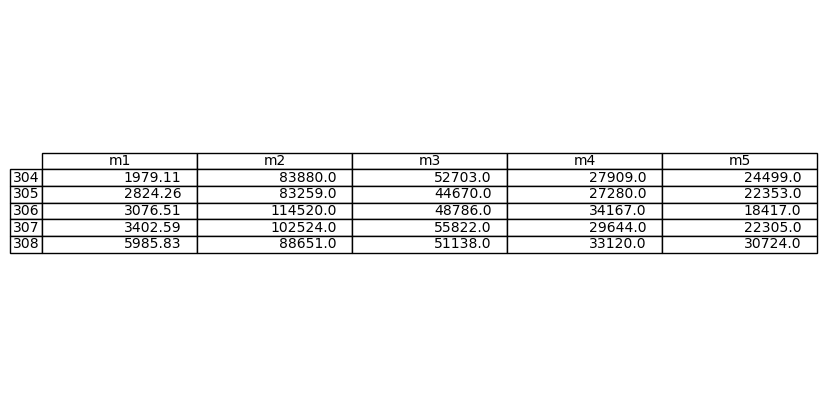

In [5]:
subset = data.iloc[-5:,:5]

# Создаем график таблицы
plt.figure(figsize=(10, 5))
plt.table(cellText=subset.values, colLabels=subset.columns,rowLabels=subset.index, loc='center')

# Отключаем координатные оси
plt.axis('off')

# Сохраняем график как изображение
plt.savefig('dataframe_subset.png')

# Отображаем график
plt.show()

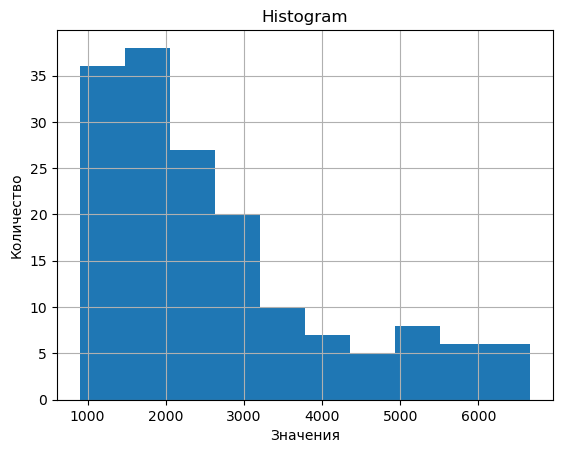

In [6]:
data.m1.hist()
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.title('Histogram')
plt.savefig("hist.png")

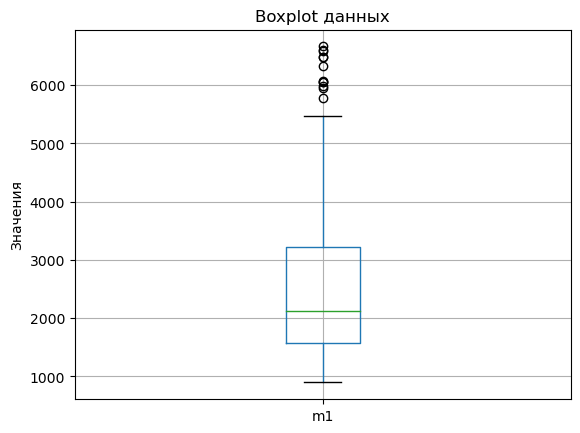

In [7]:
data.boxplot(column='m1')
plt.ylabel('Значения')
plt.title('Boxplot данных')
plt.savefig('box.png')
plt.show()

In [8]:
m1_corr = []
for x in data:
#     correlation = df['m1'].iloc[-100:].corr(df[x].iloc[-100:])
#     if(abs(correlation)>0.65):    
        correlation = data['m1'].corr(data[x])
        if(abs(correlation)>0.635):
            m1_corr.append(str(x))
            print(correlation,x)
m1_corr

1.0 m1
0.700942020021954 m27
0.6379580553613649 m28
-0.6505268763117981 m72
0.8658436203160164 m74
0.6753631100749331 m173
0.6388367799047937 m175
0.6734349663161343 m182
-0.7069007980476625 m363
-0.6540179429782647 m366


['m1', 'm27', 'm28', 'm72', 'm74', 'm173', 'm175', 'm182', 'm363', 'm366']

In [9]:
!pip install imgkit

Text(0.5, 1.0, 'm4')

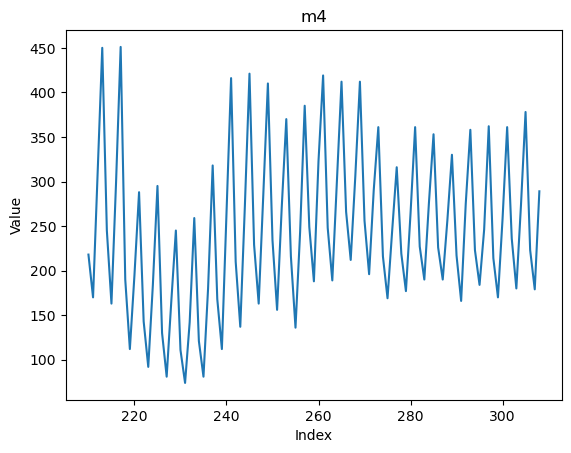

In [10]:
data.q114.plot()
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("m4")
# plt.savefig("m4.png")

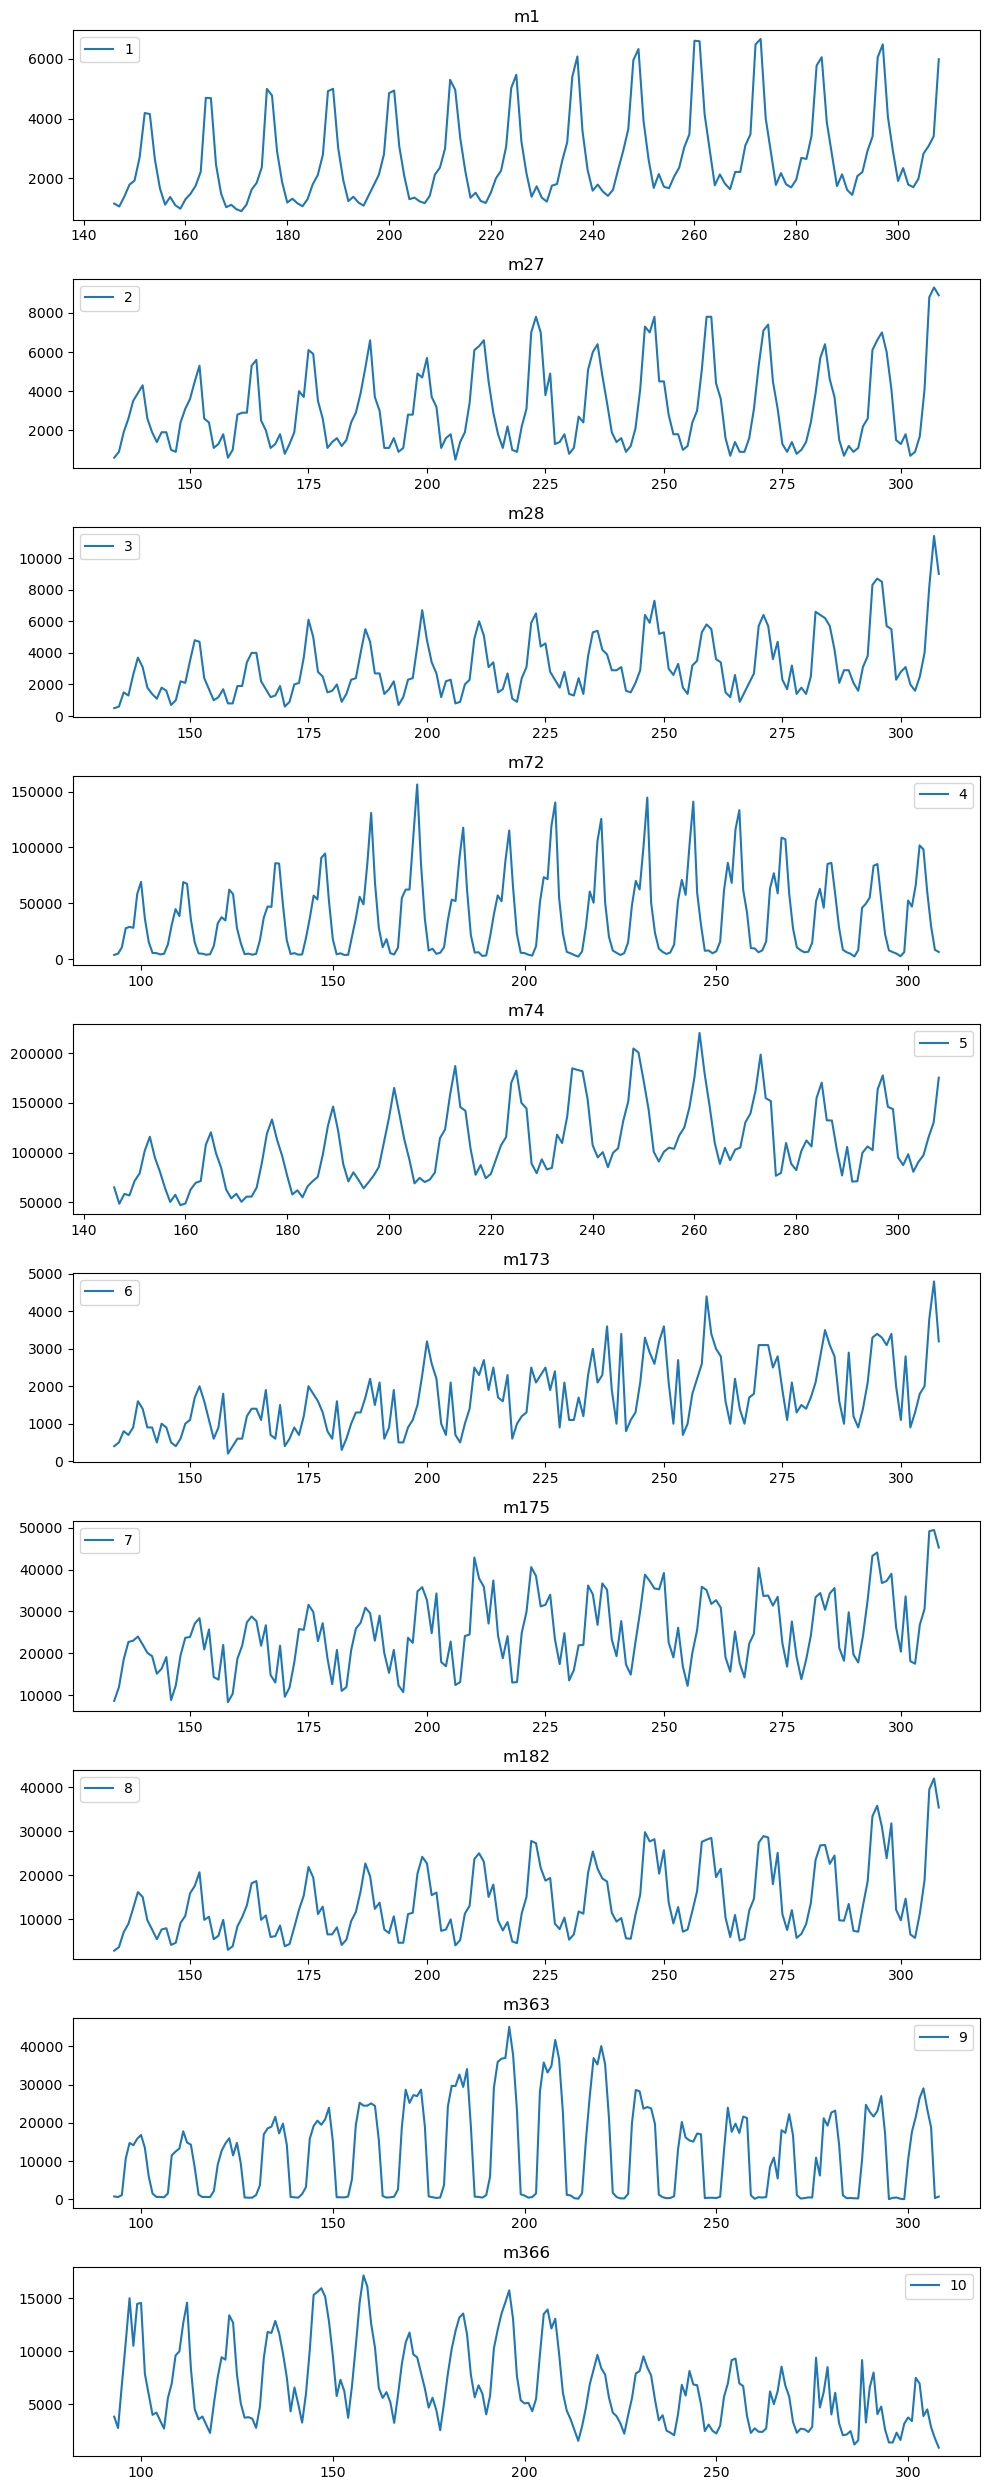

In [11]:
fig, axs = plt.subplots(len(m1_corr), 1, figsize=(10, 25))
for i,col in enumerate(m1_corr):
    axs[i].plot(data[col], label=f'{i+1}')
    axs[i].set_title(f'{col}')
    axs[i].legend()
plt.tight_layout()
plt.show()

In [12]:
l = []
for x in data:
    l.append(data[x].isna().sum())
len(data.m1)-min(l),len(data.m1)-max(l)

(309, 22)

In [39]:
data.m1.isna().sum()

146

In [14]:
data_m2 = pd.DataFrame(data.m2[69:])
data_m2.index = range(1,len(data_m2)+1)
data_m2['f_diff'] = data_m2.m2.diff(periods=12).dropna()
data_m2['s_diff'] = data_m2.f_diff.diff().dropna()

In [15]:
data_m1 = pd.DataFrame(data.m1[146:])
data_m1.index = range(1,len(data_m1)+1)
data_m1

,m1
1,1149.87
2,1053.80
3,1388.88
4,1783.37
5,1921.03
...,...
159,1979.11
160,2824.26
161,3076.51
162,3402.59


<AxesSubplot:>

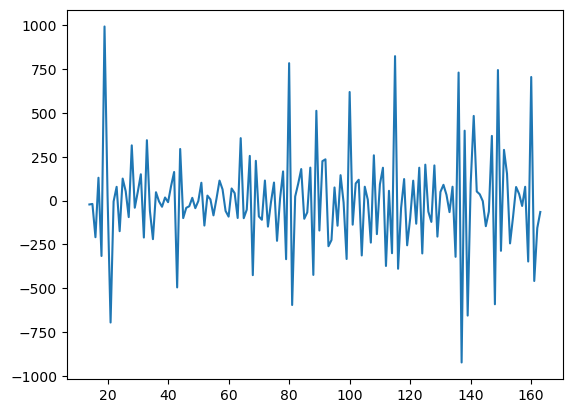

In [16]:
data_m1['f_diff'] = data_m1.m1.diff(periods=12).dropna()
data_m1['s_diff'] = data_m1.f_diff.diff().dropna()
data_m1.s_diff.plot()

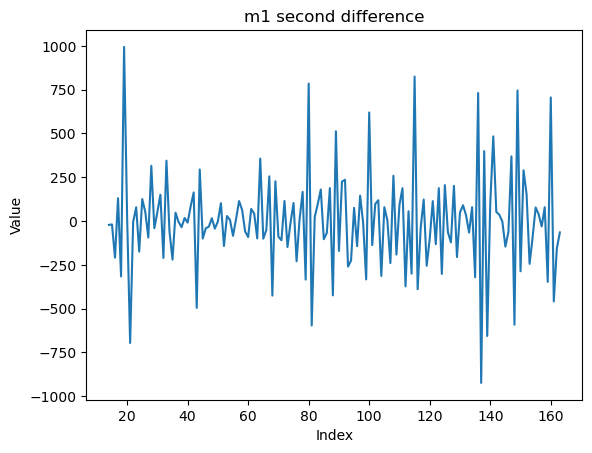

In [17]:
data_m1['s_diff'].plot()
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("m1 second difference")
plt.savefig("sec_dif.png")

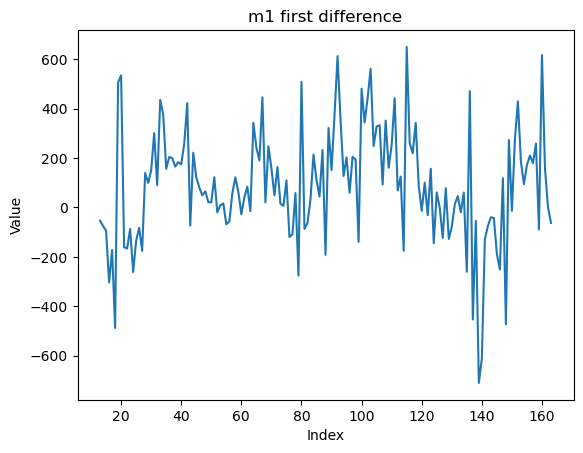

In [18]:
data_m1['f_diff'].plot()
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("m1 first difference")
plt.savefig("fir_dif.png")

In [19]:
test = sm.tsa.adfuller(data_m1.m1)
print(f'p-value --- {test[1]}')

p-value --- 0.8410408785533088


In [20]:
test = sm.tsa.adfuller(data_m1.f_diff.dropna())
print(f'p-value --- {test[1]}')

p-value --- 0.02333699308423145


In [21]:
test = sm.tsa.adfuller(data_m1.s_diff.dropna())
print(f'p-value --- {test[1]}')

p-value --- 0.0007926197503510413


In [22]:
data_m1.m1.size

163

In [34]:
data_m1.f_diff.dropna()

13     -53.55
14     -75.34
15     -94.19
16    -302.90
17    -172.16
        ...  
159    -89.13
160    616.65
161    158.10
162      1.77
163    -62.91
Name: f_diff, Length: 151, dtype: float64

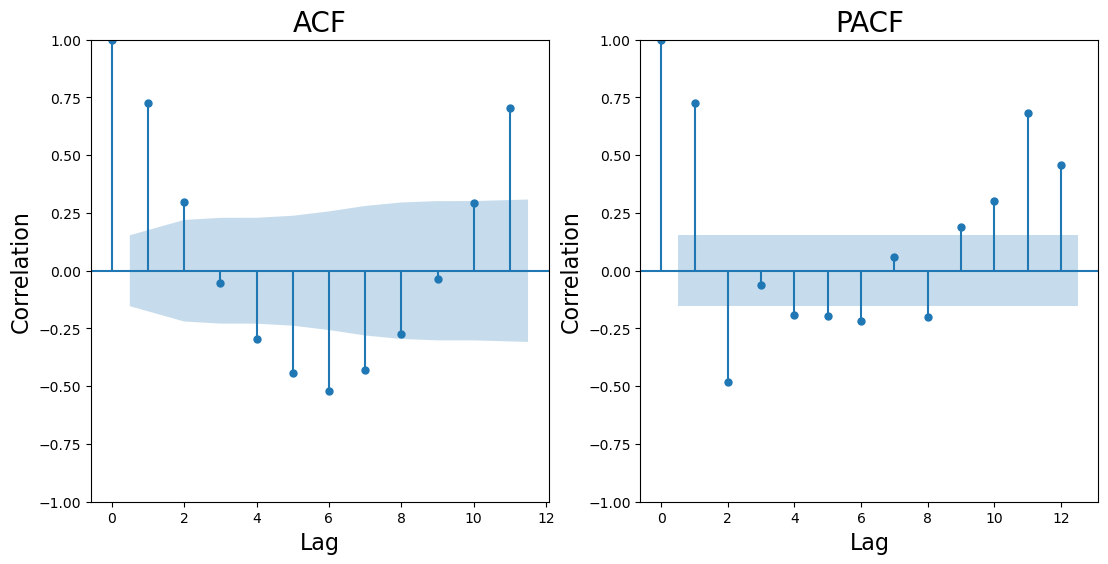

In [38]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,6))
plot_acf(data_m1.m1, lags=11, ax=ax1)
ax1.set_title('ACF',fontsize=20)
ax1.set_xlabel('Lag',fontsize=16)
ax1.set_ylabel('Correlation',fontsize=16)
plot_pacf(data_m1.m1, lags=12, ax=ax2, method='ywm')
ax2.set_title('PACF',fontsize=20)
ax2.set_ylabel('Correlation',fontsize=16)
ax2.set_xlabel('Lag',fontsize=16)
plt.savefig('sss.png')
plt.show()

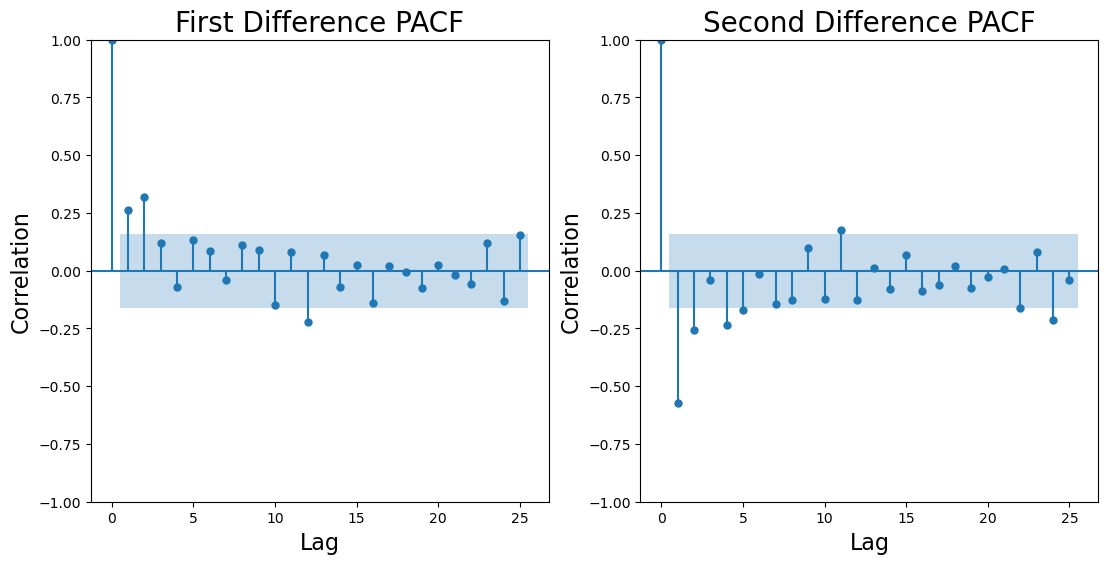

In [26]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,6))
plot_pacf(data_m1.f_diff.dropna(), lags=25, ax=ax1, method='ywm')
ax1.set_title('First Difference PACF',fontsize=20)
ax1.set_xlabel('Lag',fontsize=16)
ax1.set_ylabel('Correlation',fontsize=16)
plot_pacf(data_m1.s_diff.dropna(), lags=25, ax=ax2, method='ywm')
ax2.set_title('Second Difference PACF',fontsize=20)
ax2.set_ylabel('Correlation',fontsize=16)
ax2.set_xlabel('Lag',fontsize=16)
plt.savefig('pacf.png')
plt.show()

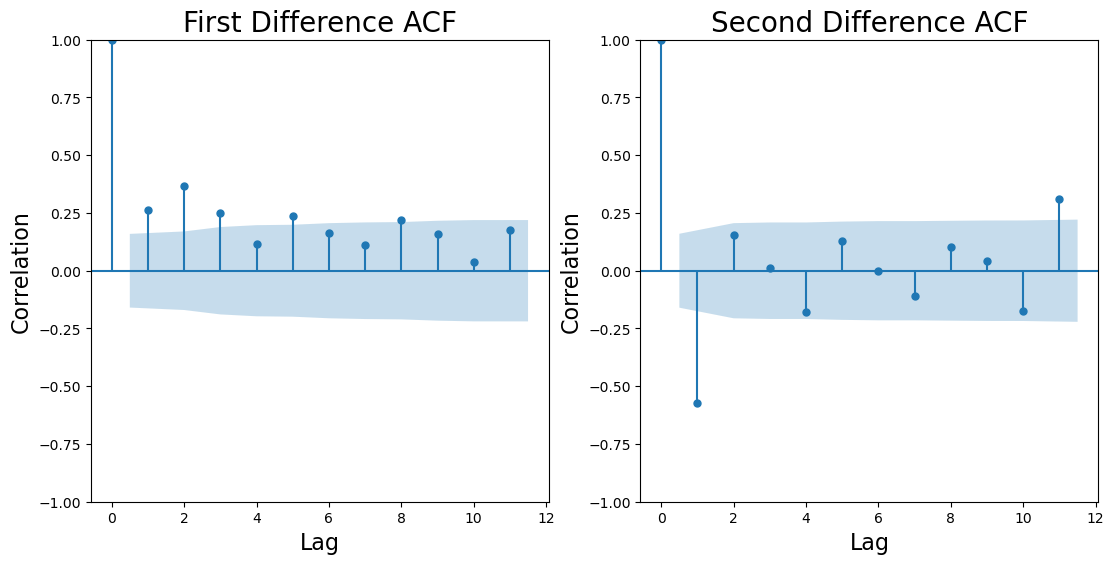

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,6))
plot_acf(data_m1.f_diff.dropna(), lags=11, ax=ax1)
ax1.set_title('First Difference ACF', fontsize=20)
ax1.set_xlabel('Lag', fontsize=16)
ax1.set_ylabel('Correlation',fontsize=16)
plot_acf(data_m1.s_diff.dropna(), lags=11, ax=ax2)
ax2.set_title('Second Difference ACF', fontsize=20)
ax2.set_xlabel('Lag', fontsize=16)
ax2.set_ylabel('Correlation',fontsize=16)
plt.savefig('acf.png')
plt.show()

In [33]:
data_m1.s_diff.dropna()

14     -21.79
15     -18.85
16    -208.71
17     130.74
18    -315.86
        ...  
159   -347.45
160    705.78
161   -458.55
162   -156.33
163    -64.68
Name: s_diff, Length: 150, dtype: float64

$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t$ - модель авторегрессии
$y_t = c + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + … + \theta_q \epsilon_{t-q} + \epsilon_t$ - модель скользящего среднего


#### Графики ACF и PACF являются двумя наиболее важными инструментами для определения базовой структуры временного ряда. График ACF показывает корреляцию временного ряда с самим собой на разных лагах, в то время как график PACF показывает корреляцию временного ряда с самим собой на разных лагах после удаления эффектов предыдущих лагов. Графики ACF и PACF можно использовать для определения порядка моделей AR, MA и ARMA.

In [84]:
data_m2z

,m2,f_diff,s_diff
1,37047.0,NaN,NaN
2,32836.0,NaN,NaN
3,51094.0,NaN,NaN
4,52629.0,NaN,NaN
5,56884.0,NaN,NaN
...,...,...,...
236,83880.0,16076.0,-31191.0
237,83259.0,11382.0,-4694.0
238,114520.0,26377.0,14995.0
239,102524.0,21139.0,-5238.0


In [35]:
data_m1.f_diff.isna().sum()

12

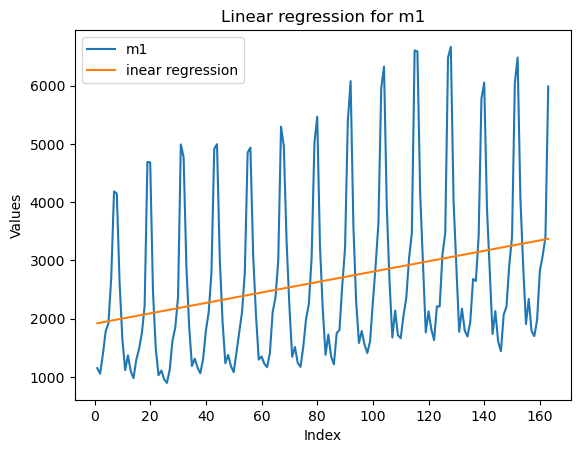

MAE = 1136.6626376311915


In [285]:
X_train = np.arange(1, data_m1.m1.size + 1).reshape(-1, 1)
y_train = data_m1.m1

lr = LinearRegression()
lr.fit(X_train, y_train)

plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Linear regression for m1")
plt.plot(X_train, y_train)
plt.plot(X_train, lr.predict(X_train))
plt.legend(['m1',
    'inear regression'
])
plt.savefig("lin.png")
plt.show()

print(f'MAE = {mean_absolute_error(data_m1.m1, lr.predict(X_train))}')

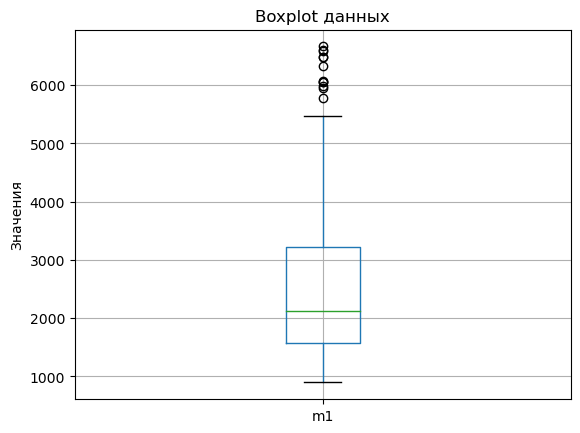

In [65]:
data.boxplot(column='m1')
plt.ylabel('Значения')
plt.title('Boxplot данных') 
plt.show()

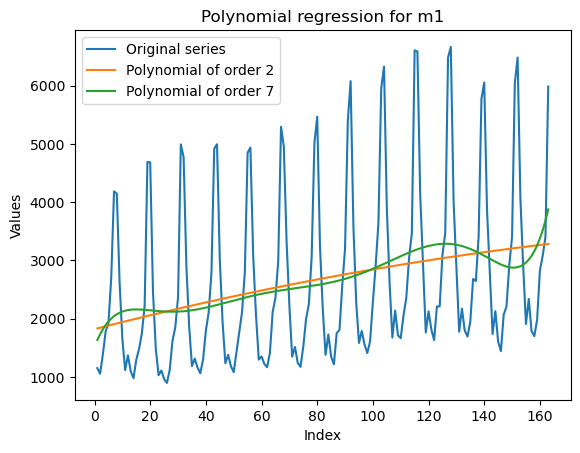

MAE = 1128.9682993346084


In [286]:
X1_train = PolynomialFeatures(2).fit_transform(X_train)
X2_train = PolynomialFeatures(7).fit_transform(X_train)

lr1 = LinearRegression().fit(X1_train, y_train)
lr2 = LinearRegression().fit(X2_train, y_train)

y_pr = lr2.predict(X2_train)
plt.plot(X_train, y_train)
plt.plot(X_train, lr1.predict(X1_train))
plt.plot(X_train, lr2.predict(X2_train))
plt.legend([
   "Original series",
"Polynomial of order 2",
"Polynomial of order 7"
])
plt.title("Polynomial regression for m1")
plt.xlabel("Index")
plt.ylabel("Values")
plt.savefig("polyreg.png")
plt.show()
print(f'MAE = {mean_absolute_error(data_m1.m1, y_pr)}')

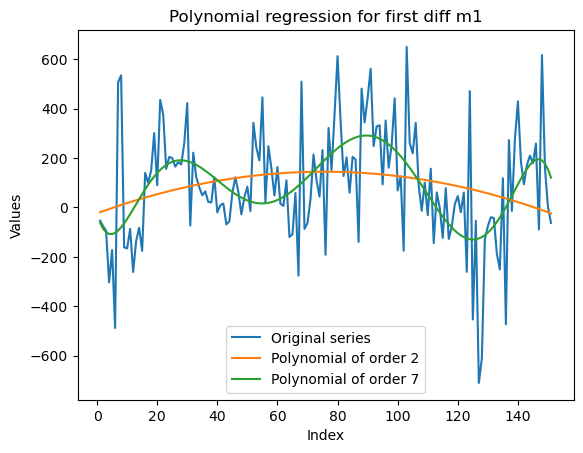

MAE = 141.98286051976282
MSE = 38826.34232270262


In [287]:
X_train = np.arange(1, data_m1.f_diff.size - 12 + 1).reshape(-1, 1)
y_train = data_m1.f_diff.dropna()

X1_train = PolynomialFeatures(2).fit_transform(X_train)
X2_train = PolynomialFeatures(7).fit_transform(X_train)

lr1 = LinearRegression().fit(X1_train, y_train)
lr2 = LinearRegression().fit(X2_train, y_train)

y_pr = lr2.predict(X2_train)
plt.plot(X_train, y_train)
plt.plot(X_train, lr1.predict(X1_train))
plt.plot(X_train, lr2.predict(X2_train))
plt.legend([
   
"Original series",
"Polynomial of order 2",
"Polynomial of order 7"
])
plt.title("Polynomial regression for first diff m1")
plt.xlabel("Index")
plt.ylabel("Values")
plt.savefig("polyregdif.png")
plt.show()
plt.show()
print(f'MAE = {mean_absolute_error(data_m1.f_diff.dropna(),  y_pr)}')
print(f'MSE = {mean_squared_error(data_m1.f_diff.dropna(),  y_pr)}')

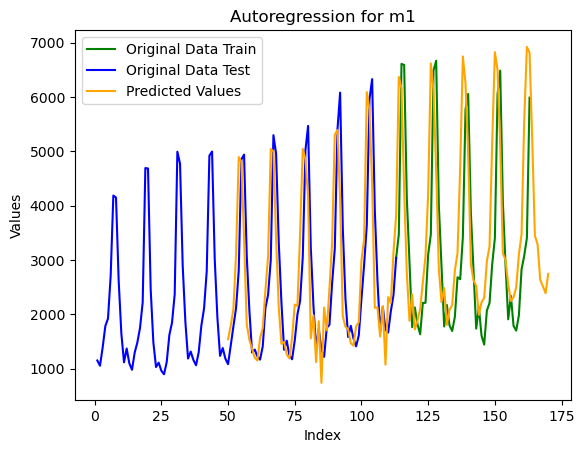

MAE = 356.3547786066673


In [144]:
lags = 11
model = sm.tsa.AutoReg(data_m1.m1.iloc[:-50], lags).fit()
start = 50
end = 170
y_pred = model.model.predict(model.params, start=start, end=end)
# y_pred = pd.Series(y_pred.values, index=data_m1.index).dropna()

data_m1.m1.iloc[-51:].plot(color='green', label='Original Data Train')
data_m1.m1.iloc[:-50].plot(color='blue',label='Original Data Test')
y_pred.plot(color='orange', label='Predicted Values')
plt.legend()
plt.title("Autoregression for m1")
plt.xlabel("Index")
plt.ylabel("Values")
plt.savefig("Autoreg.png")
plt.show()

print(f'MAE = {mean_absolute_error(data_m1.m1[start:], y_pred[0:data_m1.m1.size-start])}')

# print(f'MSE = {mean_squared_error(data_m1.m1[start:], y_pred[0:data_m1.m1.size-start])}')

## MAE = $\frac{1}{n} \sum_{i=1}^{n}{|y_{i}-\tilde y_{i}|}$

ARIMA (AutoRegressive Integrated Moving Average), Авторегрессионное интегрированное скользящее среднее — это статистическая модель, которая используется для анализа и прогнозирования данных динамических рядов. 

Авторегрессионная (AR) часть относится к использованию зависимости между текущим наблюдением и определенным количеством предыдущих наблюдений. Например, чтобы предсказать погоду на завтра, мы смотрим погоду в предыдущие дни. 

Интегрированная (I) часть обозначает, что данные временного ряда преобразуются с целью сделать ряд стационарным. Под стационарностью подразумевается такое свойство временного ряда, при котором его статистические характеристики не меняются во времени. Например, среднее и дисперсия остаются постоянными со временем. Обычно это достигается путем применения операции разности к ряду один или несколько раз. 

Скользящее среднее (MA) относится к моделированию ошибки между реальным наблюдением и прогнозируемым значением, используя комбинацию значений ошибок предыдущих шагов. 

Модель ARIMA обычно обозначается как ARIMA (p, d, q), где p, d и q — параметры модели: 

p — порядок авторегрессии, который описывает количество предыдущих наблюдений, принимаемых во внимание в модели. 

d — порядок интегрирования, который указывает, сколько раз нужно взять разность временного ряда для достижения стационарности. 

q — порядок скользящего среднего, который связан с количеством предыдущих ошибок, используемых в модели.

Выбор подходящих значений (p, d, q) в модели ARIMA — это искусство и наука, требующая обращения с автокорреляционными и частными автокорреляционными графиками, а также применения информационных критериев.

In [278]:
d_range = np.arange(1, 3)
models = []
for d in d_range:
    stepwise_fit = auto_arima(data_m1.m1, start_p = 0, start_q = 0, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = d, D = 0, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise
    models.append(stepwise_fit)
for x in models:
    print(x.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2724.515, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2722.644, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2283.747, Time=0.35 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2295.870, Time=1.08 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2506.790, Time=0.57 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2252.425, Time=0.55 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.73 s

In [45]:
best_model_index = np.argmin([m.aic() for m in models])
best_model = models[best_model_index]

# Вывод оптимальной модели
print("Оптимальная модель:")
print(best_model.summary())

Оптимальная модель:
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  163
Model:             SARIMAX(3, 2, 0)x(2, 0, [1], 12)   Log Likelihood                   0.000
Date:                              Wed, 01 May 2024   AIC                             14.000
Time:                                      13:43:53   BIC                             35.570
Sample:                                           0   HQIC                            22.758
                                              - 163                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1841   2.43e-09  -7.56e+07      0.000      -0.184      -0.184

In [46]:
def plot_col(col_name:list):
    l = len(col_name)
    if l==1:
        plt.figure(figsize=(11, 5))
        plt.plot(data[col_name[0]],label=f'{1}')
        plt.title(f"Column of {col_name[0]}")
        plt.legend()
        plt.show()
    else:
        fig, axs = plt.subplots(l, 1, figsize=(10,25))
        for i,col in enumerate(col_name):
            axs[i].plot(data[col], label=f'{i+1}')
            axs[i].set_title(f'{col}')
            axs[i].legend()
        plt.tight_layout()
        plt.show()

In [47]:
# plot_col(["m235"])

Model:             SARIMAX(3, 2, 0)x(2, 0, [1], 12)

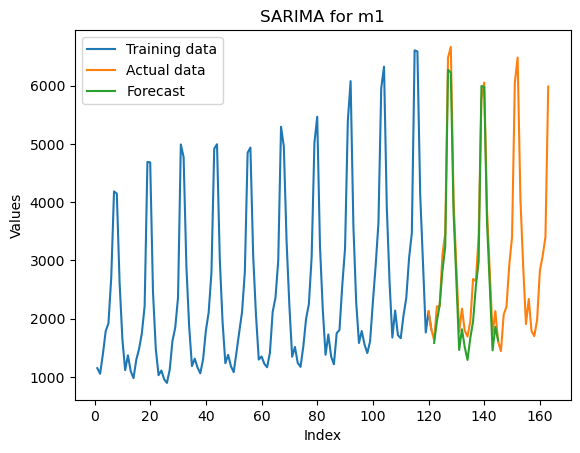

MAE = 255.24713369519995


In [295]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Создаем временной ряд для примера
ts = data_m1.m1

# Разделяем данные на обучающую и тестовую выборки
train = ts.loc[0:121]
test = ts.loc[120:]

# Задаем параметры модели SARIMAX
order = (3, 2, 0)  # порядок несезонной части ARIMA
seasonal_order = (2, 0, 1, 12) # порядок сезонной части ARIMA
trend = 't'  # тип тренда: 'n' - нет тренда, 'c' - константа, 't' - линейный тренд, 'ct' - константа и линейный тренд

# Создаем и обучаем модель SARIMAX
model = SARIMAX(train, order=order, seasonal_order=seasonal_order, trend=trend)
result = model.fit()

# Делаем прогнозы на тестовом наборе
steps=24
forecast = result.get_forecast(steps=steps)

# Отображаем исходные данные и прогнозы
plt.plot(train, label='Training data')
plt.plot(test, label='Actual data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.legend()
plt.title("SARIMA for m1")
plt.xlabel("Index")
plt.ylabel("Values")
plt.savefig("SARIMA321.png")
plt.show()
print(f'MAE = {mean_absolute_error(data_m1.m1[121:121+steps], forecast.predicted_mean)}')
# print(f'MSE = {mean_squared_error(data_m1.m1[121:121+steps], forecast.predicted_mean)}')
# data_m1.m1[120:]
# forecast.predicted_mean

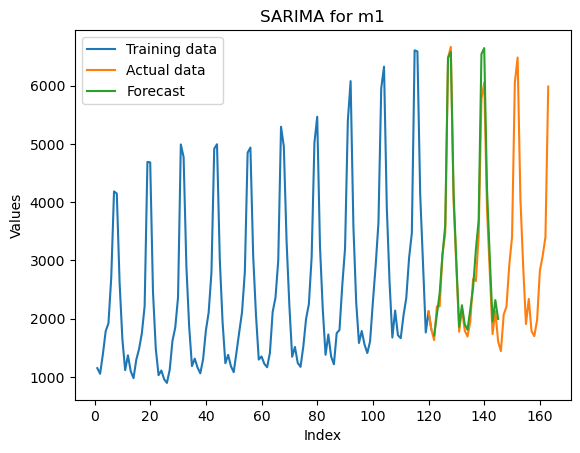

MAE = 216.91759676404195


In [298]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Создаем временной ряд для примера
ts = data_m1.m1

# Разделяем данные на обучающую и тестовую выборки
train = ts.loc[0:121]
test = ts.loc[120:]

# Задаем параметры модели SARIMAX
order = (2, 1, 0)  # порядок несезонной части ARIMA
seasonal_order = (1, 0, 1, 12) # порядок сезонной части ARIMA
trend = 't'  # тип тренда: 'n' - нет тренда, 'c' - константа, 't' - линейный тренд, 'ct' - константа и линейный тренд

# Создаем и обучаем модель SARIMAX
model = SARIMAX(train, order=order, seasonal_order=seasonal_order, trend=trend)
result = model.fit()

# Делаем прогнозы на тестовом наборе
steps= 24
forecast = result.get_forecast(steps=steps)

# Отображаем исходные данные и прогнозы
plt.plot(train, label='Training data')
plt.plot(test, label='Actual data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.legend()
plt.title("SARIMA for m1")
plt.xlabel("Index")
plt.ylabel("Values")
plt.savefig("SARIMA210.png")
plt.show()
print(f'MAE = {mean_absolute_error(data_m1.m1[121:121+steps], forecast.predicted_mean)}')
# print(f'MSE = {mean_squared_error(data_m1.m1[121:121+steps], forecast.predicted_mean)}')
# data_m1.m1[120:]
# forecast.predicted_mean